I'm building off of this: https://github.com/VinhLoiIT/signet-pytorch

In [1]:
import sys
print(sys.version)

import os
import numpy as np
import pandas as pd
import itertools
import glob
from PIL import Image, ImageOps
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
import datetime

from torch.utils.data import Dataset, DataLoader

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir /content/drive/MyDrive/Colab\ Data/
data_dir = '/content/drive/MyDrive/Colab Data/'
%cd /content/drive/MyDrive/Colab\ Data/
!mkdir cedar_signatures
%cd cedar_signatures
sig_data_dir = data_dir + 'cedar_signatures/'

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/Colab Data/’: File exists
/content/drive/MyDrive/Colab Data
mkdir: cannot create directory ‘cedar_signatures’: File exists
/content/drive/MyDrive/Colab Data/cedar_signatures


In [3]:
def download_data():
    !wget https://cedar.buffalo.edu/NIJ/data/signatures.rar -O signatures.rar
    !unrar x -y signatures.rar
    !mv signatures/* ./
    !rmdir signatures

train_test_csv_file = 'train_test_pairs.csv'
# note that the file names in the dirs are unique...
genuine_dir = sig_data_dir + 'full_org/'
forge_dir = sig_data_dir + 'full_forg/'
num_signers = 55
num_genuine_sign = 24
num_forged_sign = 24
def make_train_and_test_pairs(num_training=50, random_state=0):
    from sklearn.model_selection import train_test_split
    signers = list(range(num_signers))
    train_signers, test_signers = train_test_split(signers, \
        test_size=num_signers-num_training, random_state=random_state)

    import itertools
    # See Section 3.3
    M = num_training
    K = num_signers
    num_testing = K - M
    # 276 (geniune, genuine) signature pairs
    pair_genuine_genuine = list(itertools.combinations(range(num_genuine_sign), 2))
    # 576 (genuine, forged) signature pairs
    pair_genuine_forged = list(itertools.product(range(num_genuine_sign), range(num_forged_sign)))
    
    import random
    random.seed(random_state)

    cols = ['mode', 'signer', 'dir1', 'file1', 'dir2', 'file2', 'label']
    samples = []
    for signer_id in signers:
        mode = 'train' if signer_id in train_signers else 'test'
        for a, b in pair_genuine_genuine:
            samples.append((mode, signer_id, genuine_dir, f'original_{signer_id+1}_{a+1}.png', genuine_dir, f'original_{signer_id+1}_{b+1}.png', 1))
        # randomly trim to 276 by sampling without replacement
        sub_pair_genuine_forged = random.sample(pair_genuine_forged, len(pair_genuine_genuine))
        for a, b in sub_pair_genuine_forged:
            samples.append((mode, signer_id, genuine_dir, f'original_{signer_id+1}_{a+1}.png', forge_dir, f'forgeries_{signer_id+1}_{b+1}.png', 0))
    df = pd.DataFrame(samples, columns=cols)
    print('saving file:', train_test_csv_file)
    df.to_csv(train_test_csv_file)

    return train_signers

def get_df():
    return pd.read_csv(train_test_csv_file)

def compute_mean_and_std_dev(train_signers):
    train_imgs = [genuine_dir + f'original_{signer_id+1}_{i+1}.png' \
        for signer_id in train_signers \
            for i in range(num_genuine_sign)]\
        + [forge_dir + f'forgeries_{signer_id+1}_{i+1}.png' \
            for signer_id in train_signers \
                for i in range(num_forged_sign)]
    no_norm_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((155, 220)),
        ImageOps.invert,
        torchvision.transforms.ToTensor(),
    ])
    train_img_data = torch.stack([
        no_norm_transform(Image.open(f).convert('L')) for f in train_imgs
    ], dim=0).numpy()
    mean = train_img_data[:, :, :].mean()
    std_dev = train_img_data[:, :, :].std()
    return mean, std_dev

transform_imgs_dir = sig_data_dir + 'transformed/'
def transform_imgs(mean, std_dev):
    from torchvision.utils import save_image
    image_transform = torchvision.transforms.Compose([
        # "We resize all the images to a fixed size 155×220 using bilinear interpolation."
        torchvision.transforms.Resize((155, 220)), # Default is InterpolationMode.BILINEAR
        # "Afterwards, we invert the images so that the background pixels have 0 values."
        ImageOps.invert,
        torchvision.transforms.ToTensor(),
        # "Furthermore, we normalize each image by dividing the pixel values with the standard deviation of the pixel values of the images in a dataset."
        torchvision.transforms.Normalize(mean, std_dev),
    ])
    img_dir_files = [(genuine_dir, f'original_{signer_id+1}_{i+1}.png') \
        for signer_id in range(num_signers) \
            for i in range(num_genuine_sign)]\
        + [(forge_dir, f'forgeries_{signer_id+1}_{i+1}.png') \
            for signer_id in range(num_signers) \
                for i in range(num_forged_sign)]
    for d, f in img_dir_files:
        pil = Image.open(d + f).convert('L')
        tensor = image_transform(pil)
        save_image(tensor, transform_imgs_dir + f)

def prep_data():
    if not os.path.exists(transform_imgs_dir):
        os.mkdir(transform_imgs_dir)
        if not os.path.exists(sig_data_dir + "signatures.rar"):
            print('downloading data')
            download_data()
        print('splitting data')
        train_signers = make_train_and_test_pairs()
        print('normalizing data')
        mean, std_dev = compute_mean_and_std_dev(train_signers)
        transform_imgs(mean, std_dev)

# 2400 * 155 * 220 ~= 82 MB, so we should be fine to store it all in memory at once...
def load_imgs():
    imgs = []
    file_to_ind = {}
    # transform = torchvision.transforms.ToTensor()
    for f in os.listdir(transform_imgs_dir):
        file = os.path.join(transform_imgs_dir, f)
        # tensor = transform(torchvision.io.read_image(file, torchvision.io.ImageReadMode.GRAY))
        tensor = torchvision.io.read_image(file, torchvision.io.ImageReadMode.GRAY).float()
        file_to_ind[os.path.basename(file)] = len(imgs)
        imgs.append(tensor)
    return imgs, file_to_ind

class SignDataset(Dataset):
    def __init__(self, df, imgs):
        self.df = df
        self.imgs = imgs
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        i1, i2, y = self.df.iloc[index]
        return self.imgs[i1], self.imgs[i2], y

In [4]:
prep_data()
imgs, file_to_ind = load_imgs()
df = get_df()
df['ind1'] = df['file1'].apply(lambda x: file_to_ind[x])
df['ind2'] = df['file2'].apply(lambda x: file_to_ind[x])

train_set = SignDataset(df[df['mode'] == 'train'][['ind1', 'ind2', 'label']], imgs)
val_set = SignDataset(df[df['mode'] == 'test'][['ind1', 'ind2', 'label']], imgs)

# For SimpleNet in the assignment, I had 32 * 32 images and a batch size of 8
# To make batches the same size of data, batch size here should be 0.24
batch_size = 1 # 8 # 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory=True)

In [76]:
seed = 2020
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

'''
Reference: https://github.com/VinhLoiIT/signet-pytorch
'''
class SigNet256(nn.Module):
    '''
    Reference Keras: https://github.com/sounakdey/SigNet/blob/master/SigNet_v1.py
    '''
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            #input size = [155, 220, 1]
            nn.Conv2d(1, 96, 11), # size = [145,210]
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, k=2, alpha=1e-4, beta=0.75),
            nn.MaxPool2d(2, stride=2), # size = [72, 105]
            nn.Conv2d(96, 256, 5, padding=2, padding_mode='zeros'), # size = [72, 105]
            nn.LocalResponseNorm(size=5, k=2, alpha=1e-4, beta=0.75),
            nn.MaxPool2d(2, stride=2), # size = [36, 52]
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 384, 3, stride=1, padding=1, padding_mode='zeros'),
            nn.Conv2d(384, 256, 3, stride=1, padding=1, padding_mode='zeros'),
            nn.MaxPool2d(2, stride=2), # size = [18, 26]
            nn.Dropout2d(p=0.3),
            nn.Flatten(1, -1), # 18*26*256
            nn.Linear(18*26*256, 1024),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 256),
        )
        self.latent_dims = 256
        self.save_file = sig_data_dir+'progress_256.pt'
    def forward(self, x):
        return self.features(x)
class SigNet128(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            #input size = [155, 220, 1]
            nn.Conv2d(1, 96, 11), # size = [145,210]
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, k=2, alpha=1e-4, beta=0.75),
            nn.MaxPool2d(2, stride=2), # size = [72, 105]
            nn.Conv2d(96, 256, 5, padding=2, padding_mode='zeros'), # size = [72, 105]
            nn.LocalResponseNorm(size=5, k=2, alpha=1e-4, beta=0.75),
            nn.MaxPool2d(2, stride=2), # size = [36, 52]
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 384, 3, stride=1, padding=1, padding_mode='zeros'),
            nn.Conv2d(384, 256, 3, stride=1, padding=1, padding_mode='zeros'),
            nn.MaxPool2d(2, stride=2), # size = [18, 26]
            nn.Dropout2d(p=0.3),
            nn.Flatten(1, -1), # 18*26*256
            nn.Linear(18*26*256, 1024),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 128),
        )
        self.latent_dims = 128
        self.save_file = sig_data_dir+'progress_128.pt'
    def forward(self, x):
        return self.features(x)
class SigNet64(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            #input size = [155, 220, 1]
            nn.Conv2d(1, 96, 11), # size = [145,210]
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, k=2, alpha=1e-4, beta=0.75),
            nn.MaxPool2d(2, stride=2), # size = [72, 105]
            nn.Conv2d(96, 256, 5, padding=2, padding_mode='zeros'), # size = [72, 105]
            nn.LocalResponseNorm(size=5, k=2, alpha=1e-4, beta=0.75),
            nn.MaxPool2d(2, stride=2), # size = [36, 52]
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 384, 3, stride=1, padding=1, padding_mode='zeros'),
            nn.Conv2d(384, 256, 3, stride=1, padding=1, padding_mode='zeros'),
            nn.MaxPool2d(2, stride=2), # size = [18, 26]
            nn.Dropout2d(p=0.3),
            nn.Flatten(1, -1), # 18*26*256
            nn.Linear(18*26*256, 1024),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 64),
        )
        self.latent_dims = 64
        self.save_file = sig_data_dir+'progress_64.pt'
    def forward(self, x):
        return self.features(x)

class ContrastiveLoss(nn.Module):
    def __init__(self, alpha, beta, margin):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.margin = margin

    def forward(self, x1, x2, y):
        '''
        Shapes:
        -------
        x1: [B,C]
        x2: [B,C]
        y: [B,1]

        Returns:
        --------
        loss: [B,1]]
        '''
        distance = torch.pairwise_distance(x1, x2, p=2)
        loss = self.alpha * (1-y) * distance**2 + \
               self.beta * y * (torch.max(torch.zeros_like(distance), self.margin - distance)**2)
        return torch.mean(loss, dtype=torch.float)

class SigSystem:
    def __init__(self, model):
        model = model.to(device)
        self.net = model
        self.criterion = ContrastiveLoss(alpha=1, beta=1, margin=1).to(device)
        self.optimizer = optim.RMSprop(model.parameters(), lr=1e-5, eps=1e-8, weight_decay=5e-4, momentum=0.9)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, 5, 0.1)
        self.epoch = 0
        # self.best_training_loss = None
        self.batch = 0

        self.log_interval = 1000

        self.threshold_d = None

        self.train_loader = train_loader
        self.val_loader = val_loader
    def summary(self):
        model = self.net
        summary(model, (1, 155, 220)) # (1, 1, 155, 220)
    def leaky_accuracy(self, distances, y, step=0.01):
        min_threshold_d = min(distances)
        max_threshold_d = max(distances)
        max_acc = 0
        same_id = (y == 1)

        best_threshold_d = None
        for threshold_d in torch.arange(min_threshold_d, max_threshold_d+step, step):
            true_positive = (distances <= threshold_d) & (same_id)
            true_positive_rate = true_positive.sum().float() / same_id.sum().float()
            true_negative = (distances > threshold_d) & (~same_id)
            true_negative_rate = true_negative.sum().float() / (~same_id).sum().float()

            acc = 0.5 * (true_negative_rate + true_positive_rate)
            if acc > max_acc:
                max_acc = acc
                best_threshold_d = threshold_d
        true_positive = ((distances <= best_threshold_d) & (same_id)).sum()
        true_negative = ((distances > best_threshold_d) & (~same_id)).sum()
        false_positive = ((distances <= best_threshold_d) & (~same_id)).sum()
        false_negative = ((distances > best_threshold_d) & (same_id)).sum()
        confusion_matrix = [
            [true_positive.item(), false_negative.item()],
            [false_positive.item(), true_negative.item()],
        ]
        print('confusion matrix for', self.net.__class__.__name__, ':',\
              confusion_matrix)
        print('best leaky accuracy threshold:', best_threshold_d)
        return max_acc, best_threshold_d
    def accuracy(self, distances, y, threshold_d=None):
        if threshold_d == None:
            if self.threshold_d == None:
                self.find_threshold_simple()
            threshold_d = self.threshold_d
        same_id = (y == 1)
        true_positive = ((distances <= threshold_d) & (same_id)).sum()
        true_negative = ((distances > threshold_d) & (~same_id)).sum()
        false_positive = ((distances <= threshold_d) & (~same_id)).sum()
        false_negative = ((distances > threshold_d) & (same_id)).sum()
        confusion_matrix = [
            [true_positive.item(), false_negative.item()],
            [false_positive.item(), true_negative.item()],
        ]
        print('confusion matrix for', self.net.__class__.__name__, ':',\
              confusion_matrix)

        num_positive = same_id.sum().float()
        num_negative = (~same_id).sum().float()
        true_positive_rate = true_positive / num_positive if num_positive > 0 else 0
        true_negative_rate = true_negative / num_negative if num_negative > 0 else 0
        acc = 0.5 * (true_negative_rate + true_positive_rate)
        return acc
    # def find_threshold(num_batches=1000):
    #     latent_vector_size = self.net.latent_dims
    #     with torch.no_grad():
    #         same_ids = []
    #         deltas = []
    #         for batch_idx, (x1, x2, y) in enumerate(self.train_loader):
    #             if batch_idx > num_batches:
    #                 break
    #             x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    #             same_id = (y == 1)
    #             same_ids.append(same_id.reshape((-1, latent_vector_size))) #.cpu()

    #             x1, x2 = model(x1), model(x2)
    #             delta = torch.sub(x2, x1)
    #             deltas.append(delta.reshape((-1, latent_vector_size))) #.cpu()
    #         same_ids = torch.stack(same_ids)
    #         deltas = torch.stack(deltas)
    #         deltas_same = deltas[same_ids]
    #         deltas_diff = deltas[~same_ids]
    #         std_dev_same = torch.cov(deltas_same)
    #         std_dev_diff = torch.cov(deltas_diff)
    #         torch.cov(deltas_same)
    #         self.threshold_stds = (std_dev_same, std_dev_diff)
    #         # then, assume that everything is gaussian
    #         #     and threshold is a comparison of gaussian probabilities
    def find_threshold_simple(self, num_batches=1000):
        model = self.net
        with torch.no_grad():
            model.eval()
            i = 0
            distance_data = []
            for batch_idx, (x1, x2, y) in enumerate(train_loader):
                if batch_idx > num_batches:
                    break

                same_id = (y == 1)
                x1, x2, y = x1.to(device), x2.to(device), y.to(device)
                x1, x2 = model(x1), model(x2)
                distance_data.extend(zip(torch.pairwise_distance(x1, x2, 2).cpu().tolist(), y.cpu().tolist()))
            distances, y = zip(*distance_data)
            distances, y = torch.tensor(distances), torch.tensor(y)
            same_id = (y == 1)
            median_positive = distances[same_id].quantile(0.5)
            median_negative = distances[~same_id].quantile(0.5)
            print('medians:', median_positive, median_negative)
            self.threshold_d = (median_positive + median_negative) / 2
    def distance(self, img1, img2):
        pass
    def classify(self):
        pass
    def train(self):
        print('Training', '-'*20)
        model = self.net

        running_loss = 0
        number_samples = 0
        model.train()
        for batch_idx, (x1, x2, y) in enumerate(self.train_loader):
            if batch_idx < self.batch:
                continue
            else:
                self.batch = batch_idx

            x1, x2, y = x1.to(device), x2.to(device), y.to(device)

            self.optimizer.zero_grad()
            x1, x2 = model(x1), model(x2)
            loss = self.criterion(x1, x2, y)
            loss.backward()
            self.optimizer.step()

            number_samples += len(x1)
            running_loss += loss.item() * len(x1)
            if (batch_idx+1) % self.log_interval == 0 or batch_idx == len(self.train_loader) - 1:
                training_loss = running_loss / number_samples
                print('{}/{}: Loss: {:.4f}'.format(batch_idx, len(self.train_loader), training_loss))

                # if best_training_loss == None or training_loss <= best_training_loss:
                #     best_training_loss = training_loss
                #     print('best training loss:', best_training_loss)
                #     self.save()
                running_loss = 0
                number_samples = 0
        self.batch = 0
    def do_training(self, num_epochs=20):
        # self.load()

        for epoch in range(self.epoch, self.epoch + num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs))
            self.train()
            self.epoch = epoch
            # self.save() #('_epoch_' + str(epoch))

            # val_loss, acc = self.evaluate()
            # print('epoch_{}_loss_{:.3f}_acc_{:.3f}'.format(epoch, val_loss, acc))
            self.scheduler.step()
        self.epoch = 0
        print('Done training')
    def evaluate(self, improve_forgery=False, leaky_accuracy=False, imp_neg=False):
        print('Evaluating', '-'*20)
        # with torch.no_grad():
        model = self.net
        dataloader = self.val_loader

        model.eval()
        running_loss = 0
        number_samples = 0

        distances = []
        improved_forge_distances = []

        for batch_idx, (x1, x2, y) in enumerate(dataloader):
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)

            if improve_forgery:
                # todo: I could avoid recomputing some latent vectors here
                diff_id = (y != 1)
                diff_x1 = x1.clone()[diff_id]
                diff_x2 = x2.clone()[diff_id]
                imp_x2, _, diff_x1, _ = self.improve_forge(diff_x1, diff_x2) if not imp_neg else self.improve_forge_neg(diff_x1, diff_x2)
                # imp_x2 = imp_x2.to(device)
                imp_x2 = model(imp_x2)
                improved_forge_distances.extend(torch.pairwise_distance(diff_x1, imp_x2, 2).cpu().tolist())
            x1 = model(x1)
            x2 = model(x2)
            loss = self.criterion(x1, x2, y)
            distances.extend(zip(torch.pairwise_distance(x1, x2, 2).cpu().tolist(), y.cpu().tolist()))

            number_samples += len(x1)
            running_loss += loss.item() * len(x1)

            if (batch_idx + 1) % self.log_interval == 0 or batch_idx == len(dataloader) - 1:
                print('{}/{}: Loss: {:.4f}'\
                        .format(batch_idx+1, len(dataloader), running_loss / number_samples))

        distances, y = zip(*distances)
        distances, y = torch.tensor(distances), torch.tensor(y)
        print('computing accuracy of normal pairs...')
        acc = None
        leaky_threshold_d = None
        if not leaky_accuracy:
            acc = self.accuracy(distances, y)
        else:
            acc, leaky_threshold_d = self.leaky_accuracy(distances, y)
        print('Accuracy:', acc)
        imp_distances = None
        if improve_forgery:
            print('computing accuracy of improved forges...')
            imp_distances = torch.tensor(improved_forge_distances)
            imp_y = torch.tensor([0] * len(improved_forge_distances))
            imp_acc = self.accuracy(imp_distances, imp_y, threshold_d=leaky_threshold_d)
            print(f'Accuracy on improved forges: {imp_acc}')
        val_loss = running_loss / number_samples
        print('val loss:', val_loss)
        return val_loss, acc, distances, y, imp_distances, imp_y
    def save(self, tag=""):
        print('Saving checkpoint..', tag)
        save_file = self.net.save_file + tag
        to_save = {
            'model': self.net.state_dict(),
            'scheduler': self.scheduler.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epoch': self.epoch,
            'batch': self.batch,
            # 'training_loss': self.training_loss,
            'threshold_d': self.threshold_d,
        }
        torch.save(to_save, save_file)
    def load(self, tag=""):
        save_file = self.net.save_file + tag
        if os.path.exists(save_file):
            print('loading from checkpoint')
            checkpoint = torch.load(save_file)
            self.net.load_state_dict(checkpoint['model'])
            self.scheduler.load_state_dict(checkpoint['scheduler'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.epoch = checkpoint['epoch']
            self.batch = checkpoint['batch']
            # self.best_training_loss = checkpoint['training_loss']

            self.threshold_d = checkpoint.get('threshold_d')
    def improve_forge(self, genuines, forges, eps=0.004, same=1):
        model = self.net
        model.eval() # set training flag to false to avoid batch norm and/or dropout
        forges = forges.to(device)
        genuines = genuines.to(device)
        forges.requires_grad = True
    
        target_outputs = model(genuines) # todo: cache these?
        outputs = model(forges)

        model.zero_grad()
        loss = self.criterion(outputs, target_outputs, same).to(device)
        loss.backward() # I guess this populates the gradients?

        perturbations = eps*forges.grad
        improved_forges = forges + perturbations
        improved_forges = torch.clamp(improved_forges, 0, 1)

        return improved_forges, perturbations, target_outputs, outputs
    def improve_forge_neg(self, genuines, forges, eps=0.004, same=1):
        model = self.net
        model.eval() # set training flag to false to avoid batch norm and/or dropout
        forges = forges.to(device)
        genuines = genuines.to(device)
        forges.requires_grad = True
    
        target_outputs = model(genuines) # todo: cache these?
        outputs = model(forges)

        model.zero_grad()
        loss = self.criterion(outputs, target_outputs, same).to(device)
        loss.backward() # I guess this populates the gradients?

        perturbations = eps*forges.grad.sign()
        improved_forges = forges + perturbations
        improved_forges = torch.clamp(improved_forges, 0, 1)

        return improved_forges, perturbations, target_outputs, outputs

Device: cuda


In [ ]:
# This (will take many hours and then) generates the main results
systems = [
    SigSystem(SigNet64()),
    SigSystem(SigNet128()),
    SigSystem(SigNet256()),
]
for s in systems:
    s.summary()
    s.load()
    s.do_training()
    s.find_threshold_simple()
    s.save()
    s.evaluate(improve_forgery=True, leaky_accuracy=False, imp_neg=True)
    s.evaluate(improve_forgery=True, leaky_accuracy=True, imp_neg=True)

# **Beware**:

---


The below cells are leftover from many small tests and will not run without some coercion!

In [25]:
systems = [
    SigSystem(SigNet64()),
    SigSystem(SigNet128()),
    SigSystem(SigNet256()),
]
for s in systems:
    s.summary()
    s.load()
    # s.do_training()
    # s.find_threshold_simple()
    s.evaluate(improve_forgery=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 145, 210]          11,712
              ReLU-2         [-1, 96, 145, 210]               0
 LocalResponseNorm-3         [-1, 96, 145, 210]               0
         MaxPool2d-4          [-1, 96, 72, 105]               0
            Conv2d-5         [-1, 256, 72, 105]         614,656
 LocalResponseNorm-6         [-1, 256, 72, 105]               0
         MaxPool2d-7          [-1, 256, 36, 52]               0
         Dropout2d-8          [-1, 256, 36, 52]               0
            Conv2d-9          [-1, 384, 36, 52]         885,120
           Conv2d-10          [-1, 256, 36, 52]         884,992
        MaxPool2d-11          [-1, 256, 18, 26]               0
        Dropout2d-12          [-1, 256, 18, 26]               0
          Flatten-13               [-1, 119808]               0
           Linear-14                 [-

In [32]:
systems = [
    SigSystem(SigNet64()),
    SigSystem(SigNet128()),
    SigSystem(SigNet256()),
]

# systems[0].do_training(num_epochs=1)
systems[1].do_training(num_epochs=1)
systems[2].do_training(num_epochs=1)
systems[1].do_training(num_epochs=1)
systems[1].do_training(num_epochs=1)

loading from checkpoint


RuntimeError: ignored

In [45]:
# del systems
# del s
torch.cuda.empty_cache()

In [47]:
SigSystem(SigNet64()).do_training()
torch.cuda.empty_cache()

Epoch 0/20
Training --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


999/27600: Loss: 182361.1489
1999/27600: Loss: 650.0819
2999/27600: Loss: 155.6958
3999/27600: Loss: 11.4456
4999/27600: Loss: 1.2639
5999/27600: Loss: 0.5376
6999/27600: Loss: 0.4463
7999/27600: Loss: 0.3981
8999/27600: Loss: 0.3850
9999/27600: Loss: 0.3898
10999/27600: Loss: 0.3726
11999/27600: Loss: 0.3913
12999/27600: Loss: 0.3870
13999/27600: Loss: 0.3748
14999/27600: Loss: 0.4019
15999/27600: Loss: 0.3924
16999/27600: Loss: 0.5530
17999/27600: Loss: 0.3734
18999/27600: Loss: 0.3871
19999/27600: Loss: 0.3906
20999/27600: Loss: 0.7573
21999/27600: Loss: 2.3745
22999/27600: Loss: 0.4887
23999/27600: Loss: 0.7214
24999/27600: Loss: 0.6736
25999/27600: Loss: 1.0229
26999/27600: Loss: 1.3326
27599/27600: Loss: 11.0594
Saving checkpoint.. _epoch_0
Evaluating --------------------
1000/2760: Loss: 0.4588
2000/2760: Loss: 0.4669
2760/2760: Loss: 0.4202
computing accuracy of normal pairs...
medians: tensor(0.0916) tensor(0.2944)
confusion matrix for SigNet64 : [[947, 433], [272, 1108]]
Accu

KeyboardInterrupt: ignored

In [6]:
s = SigSystem(SigNet128())
s.do_training()

Epoch 0/20
Training --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


999/27600: Loss: 644549.5492
1999/27600: Loss: 3392.4065
2999/27600: Loss: 647.0832
3999/27600: Loss: 24.6943
4999/27600: Loss: 5.2430
5999/27600: Loss: 1.7139
6999/27600: Loss: 0.5576
7999/27600: Loss: 0.4404
8999/27600: Loss: 0.3944
9999/27600: Loss: 0.3820
10999/27600: Loss: 0.3892
11999/27600: Loss: 0.3911
12999/27600: Loss: 0.3986
13999/27600: Loss: 0.3789
14999/27600: Loss: 0.3757
15999/27600: Loss: 0.8989
16999/27600: Loss: 1.0209
17999/27600: Loss: 0.3823
18999/27600: Loss: 0.3936
19999/27600: Loss: 0.6881
20999/27600: Loss: 0.5928
21999/27600: Loss: 0.8750
22999/27600: Loss: 0.3563
23999/27600: Loss: 0.7078
24999/27600: Loss: 3.2152
25999/27600: Loss: 2.4093
26999/27600: Loss: 4.1829
27599/27600: Loss: 0.5623
Saving checkpoint.. 
Evaluating --------------------
1000/2760: Loss: 0.4860
2000/2760: Loss: 0.4829
2760/2760: Loss: 0.4338
computing accuracy of normal pairs...
medians: tensor(0.0649) tensor(0.1475)
confusion matrix for SigNet128 : [[930, 450], [302, 1078]]
Accuracy: t

KeyboardInterrupt: ignored

In [7]:
s.do_training(num_epochs=19)

loading from checkpoint
Epoch 0/19
Training --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


999/27600: Loss: 1.7450
1999/27600: Loss: 5.7623
2999/27600: Loss: 0.3657
3999/27600: Loss: 192.9477
4999/27600: Loss: 3.2241
5999/27600: Loss: 40.1067
6999/27600: Loss: 1.2819
7999/27600: Loss: 0.5081
8999/27600: Loss: 4.2211
9999/27600: Loss: 11.5689
10999/27600: Loss: 1.8486
11999/27600: Loss: 0.9318
12999/27600: Loss: 3.0272
13999/27600: Loss: 8.6754
14999/27600: Loss: 4.4584
15999/27600: Loss: 1.3803
16999/27600: Loss: 6.7599
17999/27600: Loss: 10.6009
18999/27600: Loss: 1.9834
19999/27600: Loss: 126.7831
20999/27600: Loss: 1.5574
21999/27600: Loss: 8.5621
22999/27600: Loss: 4.3075
23999/27600: Loss: 11.8949
24999/27600: Loss: 19.5003
25999/27600: Loss: 10.4538
26999/27600: Loss: 75.5833
27599/27600: Loss: 7.5154
Saving checkpoint.. 
Evaluating --------------------
1000/2760: Loss: 0.5226
2000/2760: Loss: 0.5320
2760/2760: Loss: 0.4787
computing accuracy of normal pairs...
medians: tensor(0.0105) tensor(0.1114)
confusion matrix for SigNet128 : [[1025, 355], [204, 1176]]
Accuracy: 

KeyboardInterrupt: ignored

In [9]:
s.epoch = 5
s.save()

Saving checkpoint.. 


In [11]:
del s
torch.cuda.empty_cache()

In [12]:
s = SigSystem(SigNet256())
s.do_training(num_epochs=5)

Epoch 0/5
Training --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


999/27600: Loss: 95941.2071
1999/27600: Loss: 405.7756
2999/27600: Loss: 127.7243
3999/27600: Loss: 22.8133
4999/27600: Loss: 1.4741
5999/27600: Loss: 0.4849
6999/27600: Loss: 0.4454
7999/27600: Loss: 0.3859
8999/27600: Loss: 0.4030
9999/27600: Loss: 0.3833
10999/27600: Loss: 0.3926
11999/27600: Loss: 0.3967
12999/27600: Loss: 0.3761
13999/27600: Loss: 0.8095
14999/27600: Loss: 0.3722
15999/27600: Loss: 1.4978
16999/27600: Loss: 4.2712
17999/27600: Loss: 0.4109
18999/27600: Loss: 3.2043
19999/27600: Loss: 1.0642
20999/27600: Loss: 9.4291
21999/27600: Loss: 0.9221
22999/27600: Loss: 3.0742
23999/27600: Loss: 8.7095
24999/27600: Loss: 6.4743
25999/27600: Loss: 38.7489
26999/27600: Loss: 9.1999
27599/27600: Loss: 0.5797
Saving checkpoint.. 
Epoch 1/5
Training --------------------
999/27600: Loss: 2.0544
1999/27600: Loss: 0.8539
2999/27600: Loss: 8.0209
3999/27600: Loss: 1.0203
4999/27600: Loss: 14.1491
5999/27600: Loss: 0.5441
6999/27600: Loss: 152.0388
7999/27600: Loss: 1.6255
8999/27600

In [17]:
s.evaluate(improve_forgery=True)

Evaluating --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


1000/2760: Loss: nan
2000/2760: Loss: nan
2760/2760: Loss: nan
computing accuracy of normal pairs...
confusion matrix for SigNet256 : [[0, 0], [88, 1292]]
Accuracy: tensor(nan)
computing accuracy of improved forges...
confusion matrix for SigNet256 : [[0, 0], [377, 1003]]
Accuracy on improved forges: nan
val loss: nan


(nan, tensor(nan))

In [18]:
s.evaluate()

Evaluating --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


1000/2760: Loss: 0.4955
2000/2760: Loss: 0.4895
2760/2760: Loss: 0.4360
computing accuracy of normal pairs...
confusion matrix for SigNet256 : [[729, 651], [88, 1292]]
Accuracy: tensor(0.7322)
val loss: 0.43599748800043014


(0.43599748800043014, tensor(0.7322))

In [34]:
s = SigSystem(SigNet256())
s.load()
s.evaluate(improve_forgery=True)

loading from checkpoint
Evaluating --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


1000/2760: Loss: 0.4955
2000/2760: Loss: 0.4895
2760/2760: Loss: 0.4360
computing accuracy of normal pairs...
medians: tensor(0.0158) tensor(0.1036)
confusion matrix for SigNet256 : [[729, 651], [88, 1292]]
Accuracy: tensor(0.7322)
computing accuracy of improved forges...
confusion matrix for SigNet256 : [[0, 0], [377, 1003]]
Accuracy on improved forges: nan
val loss: 0.43599748800043014


(0.43599748800043014, tensor(0.7322))

In [46]:
# del s
torch.cuda.empty_cache()

In [43]:
s = SigSystem(SigNet128())
s.load('_epoch_4')
s.find_threshold_simple()
s.save('_epoch_4')
s.evaluate(improve_forgery=True)

loading from checkpoint


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


medians: tensor(0.0301) tensor(0.2113)
Saving checkpoint.. _epoch_4
Evaluating --------------------
1000/2760: Loss: 0.5052
2000/2760: Loss: 0.5103
2760/2760: Loss: 0.4624
computing accuracy of normal pairs...
confusion matrix for SigNet128 : [[1044, 336], [224, 1156]]
Accuracy: tensor(0.7971)
computing accuracy of improved forges...
confusion matrix for SigNet128 : [[0, 0], [1211, 169]]
Accuracy on improved forges: 0.061231885105371475
val loss: 0.4624339378927328


(0.4624339378927328, tensor(0.7971))

In [39]:
s = SigSystem(SigNet64())
s.load(tag='_epoch_19')
s.evaluate(improve_forgery=True)

loading from checkpoint
Evaluating --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


1000/2760: Loss: 0.5465
2000/2760: Loss: 0.5464
2760/2760: Loss: 0.4937
computing accuracy of normal pairs...
confusion matrix for SigNet64 : [[1380, 0], [1380, 0]]
Accuracy: tensor(0.5000)
computing accuracy of improved forges...
confusion matrix for SigNet64 : [[0, 0], [1380, 0]]
Accuracy on improved forges: 0.0
val loss: 0.49372581484056066


(0.49372581484056066, tensor(0.5000))

In [40]:
s.find_threshold_simple()
s.evaluate(improve_forgery=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


medians: tensor(0.0053) tensor(0.0549)
Evaluating --------------------
1000/2760: Loss: 0.5465
2000/2760: Loss: 0.5464
2760/2760: Loss: 0.4937
computing accuracy of normal pairs...
confusion matrix for SigNet64 : [[1347, 33], [0, 1380]]
Accuracy: tensor(0.9880)
computing accuracy of improved forges...
confusion matrix for SigNet64 : [[0, 0], [39, 1341]]
Accuracy on improved forges: 0.48586955666542053
val loss: 0.49372581484056066


(0.49372581484056066, tensor(0.9880))

In [48]:
s = SigSystem(SigNet64())
s.do_training(num_epochs=5)
s.find_threshold_simple()
s.save('_epoch_4')
s.evaluate(improve_forgery=True)

Epoch 0/5
Training --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


999/27600: Loss: 186183.1671
1999/27600: Loss: 1577.7957
2999/27600: Loss: 73.1049
3999/27600: Loss: 42.1069
4999/27600: Loss: 2.7704
5999/27600: Loss: 1.0964
6999/27600: Loss: 0.4747
7999/27600: Loss: 0.4088
8999/27600: Loss: 0.3811
9999/27600: Loss: 0.3957
10999/27600: Loss: 0.3933
11999/27600: Loss: 0.3764
12999/27600: Loss: 0.4020
13999/27600: Loss: 0.4026
14999/27600: Loss: 0.4937
15999/27600: Loss: 0.3700
16999/27600: Loss: 0.3729
17999/27600: Loss: 0.3944
18999/27600: Loss: 0.4645
19999/27600: Loss: 0.4047
20999/27600: Loss: 1.8152
21999/27600: Loss: 0.3866
22999/27600: Loss: 4.1024
23999/27600: Loss: 0.6654
24999/27600: Loss: 0.4151
25999/27600: Loss: 0.7877
26999/27600: Loss: 18.9972
27599/27600: Loss: 1.0707
Saving checkpoint.. 
Epoch 1/5
Training --------------------
999/27600: Loss: 1.0809
1999/27600: Loss: 1.7550
2999/27600: Loss: 1.6073
3999/27600: Loss: 4.5949
4999/27600: Loss: 98.0048
5999/27600: Loss: 0.5648
6999/27600: Loss: 0.3853
7999/27600: Loss: 1.3161
8999/27600:

(0.4882432461388078, tensor(0.9130))

In [7]:
s = SigSystem(SigNet128())
s.load('_epoch_4')
s.do_training(num_epochs=15)
s.save('_epoch_19')
s.find_threshold_simple()
s.save('_epoch_19')
s.evaluate(improve_forgery=True)

loading from checkpoint
Epoch 0/15
Training --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


999/27600: Loss: 8.5569
1999/27600: Loss: 1.7509
2999/27600: Loss: 1.4547
3999/27600: Loss: 11.5801
4999/27600: Loss: 10.6094
5999/27600: Loss: 0.7825
6999/27600: Loss: 9.7563
7999/27600: Loss: 20.8306
8999/27600: Loss: 46.6693
9999/27600: Loss: 8.4710
10999/27600: Loss: 41.5695
11999/27600: Loss: 28.5675
12999/27600: Loss: 12.2699
13999/27600: Loss: 37.2105
14999/27600: Loss: 7.0749
15999/27600: Loss: 9.2441
16999/27600: Loss: 26.2209
17999/27600: Loss: 270.6970
18999/27600: Loss: 4.8448
19999/27600: Loss: 1.0654
20999/27600: Loss: 0.9358
21999/27600: Loss: 3.9766
22999/27600: Loss: 5.2392
23999/27600: Loss: 2.3069
24999/27600: Loss: 28.6453
25999/27600: Loss: 10.8078
26999/27600: Loss: 11.9862
27599/27600: Loss: 0.3830
Epoch 1/15
Training --------------------
999/27600: Loss: 4.4590
1999/27600: Loss: 5.5640
2999/27600: Loss: 0.7829
3999/27600: Loss: 4.5059
4999/27600: Loss: 4.0028
5999/27600: Loss: 2.6548
6999/27600: Loss: 1.2487
7999/27600: Loss: 1.2623
8999/27600: Loss: 4.1220
9999

(0.4966573580144145, tensor(0.9949))

In [8]:
del s
torch.cuda.empty_cache()

In [9]:
s = SigSystem(SigNet256())
s.load('_epoch_4')
s.do_training(num_epochs=15)
s.save('_epoch_19')
s.find_threshold_simple()
s.save('_epoch_19')
s.evaluate(improve_forgery=True)

loading from checkpoint
Epoch 4/15
Training --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


999/27600: Loss: 12.8005
1999/27600: Loss: 13.4281
2999/27600: Loss: 7.3098
3999/27600: Loss: 42.9278
4999/27600: Loss: 19.8376
5999/27600: Loss: 27.7437
6999/27600: Loss: 18.0512
7999/27600: Loss: 7.8616
8999/27600: Loss: 1.3022
9999/27600: Loss: 31.3654
10999/27600: Loss: 7.6130
11999/27600: Loss: 3.8032
12999/27600: Loss: 7.5300
13999/27600: Loss: 1.0731
14999/27600: Loss: 13.7372
15999/27600: Loss: 17.4663
16999/27600: Loss: 11.2563
17999/27600: Loss: 5.0469
18999/27600: Loss: 21.8113
19999/27600: Loss: 9.3465
20999/27600: Loss: 31.5859
21999/27600: Loss: 1301.1331
22999/27600: Loss: 163.3469
23999/27600: Loss: 18.4595
24999/27600: Loss: 7.2528
25999/27600: Loss: 121.0091
26999/27600: Loss: 7.7265
27599/27600: Loss: 0.7660
Epoch 5/15
Training --------------------
999/27600: Loss: 0.3449
1999/27600: Loss: 0.3451
2999/27600: Loss: 0.3505
3999/27600: Loss: 0.3436
4999/27600: Loss: 0.3210
5999/27600: Loss: 0.3496
6999/27600: Loss: 0.2949
7999/27600: Loss: 0.2819
8999/27600: Loss: 0.290

(0.4940105343219382, tensor(0.9902))

In [11]:
del s
torch.cuda.empty_cache()

In [16]:
s = SigSystem(SigNet128())
s.load('_epoch_19')
result = s.evaluate(improve_forgery=True, leaky_accuracy=True)

loading from checkpoint
Evaluating --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


1000/2760: Loss: 0.5499
2000/2760: Loss: 0.5498
2760/2760: Loss: 0.4967
computing accuracy of normal pairs...
Accuracy: tensor(0.9967)
computing accuracy of improved forges...
confusion matrix for SigNet128 : [[0, 0], [296, 1084]]
Accuracy on improved forges: 0.39275363087654114
val loss: 0.4966573580144145


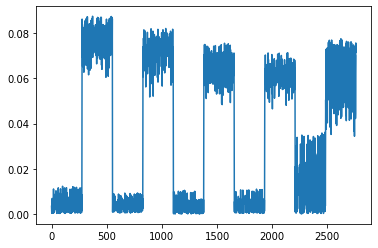

In [20]:
plt.plot(result[2])

(array([294., 242.,  74.,  89.,  77.,  82., 101., 101.,  39.,  48.,  50.,
         28.,  22.,   9.,   0.,   1.,   6.,   2.,   7.,   6.,   2.,   0.,
          5.,   6.,  16.,   8.,   8.,   5.,   4.,   6.,   7.,   1.,   4.,
          1.,   5.,   6.,   2.,   2.,   2.,  10.,   3.,   2.,   2.,   1.,
          2.,   1.,   1.,   3.,   5.,   3.,   5.,   3.,   4.,   7.,   2.,
          5.,   8.,   9.,  10.,  10.,  10.,   9.,   9.,  16.,  30.,  35.,
         34.,  35.,  42.,  21.,  43.,  20.,  46.,  51.,  56.,  65.,  31.,
         32.,  41.,  45.,  65.,  76.,  51.,  56.,  79.,  66.,  43.,  30.,
         19.,  24.,  27.,  18.,   7.,  11.,  15.,  10.,   2.,   3.,  10.,
         13.]),
 array([0.00022119, 0.00109132, 0.00196146, 0.00283159, 0.00370172,
        0.00457185, 0.00544199, 0.00631212, 0.00718225, 0.00805238,
        0.00892252, 0.00979265, 0.01066278, 0.01153292, 0.01240305,
        0.01327318, 0.01414331, 0.01501345, 0.01588358, 0.01675371,
        0.01762384, 0.01849398, 0.01936411, 0.

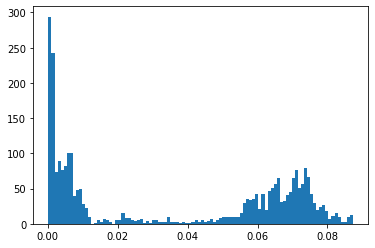

In [23]:
plt.hist(result[2], bins=100)

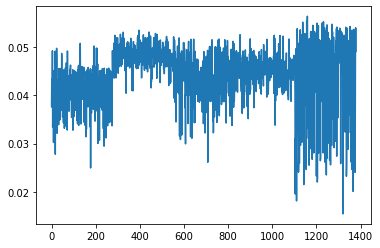

In [21]:
plt.plot(result[3])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  1.,  1.,  1.,  1.,  0.,  3.,  0.,  2.,  4.,  1.,  2.,  4.,
         4.,  2.,  3.,  1.,  6.,  1.,  1.,  3.,  3.,  3.,  5.,  4.,  4.,
         4.,  6.,  6.,  5.,  5., 11., 12., 12.,  6.,  5., 10.,  6.,  7.,
        11., 14., 11.,  9., 20., 19., 15., 19., 30., 31., 19., 14., 24.,
        15., 20., 30., 32., 24., 42., 41., 53., 50., 51., 47., 49., 44.,
        54., 45., 34., 41., 52., 33., 35., 15., 29., 31., 28., 24., 19.,
        14., 11.,  6.,  6.,  4.,  2.,  3.,  0.,  1.]),
 array([0.01542225, 0.01583165, 0.01624106, 0.01665046, 0.01705987,
        0.01746927, 0.01787867, 0.01828808, 0.01869748, 0.01910688,
        0.01951629, 0.01992569, 0.0203351 , 0.0207445 , 0.0211539 ,
        0.02156331, 0.02197271, 0.02238211, 0.02279152, 0.02320092,
        0.02361032, 0.02401973, 0.02442913, 0.02483854, 0.02524794,
        0.02565734, 0.02606674, 0.02647615, 0.02688555, 0.02729496,
        0.02770436, 0.0281

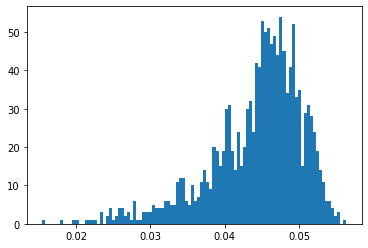

In [25]:
plt.hist(result[3], bins=100)

In [35]:
s = SigSystem(SigNet128())
s.load('_epoch_19')
result = s.evaluate(improve_forgery=True, leaky_accuracy=True)

loading from checkpoint
Evaluating --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


1000/2760: Loss: 0.5499
2000/2760: Loss: 0.5498
2760/2760: Loss: 0.4967
computing accuracy of normal pairs...
Accuracy: tensor(0.9967)
computing accuracy of improved forges...
confusion matrix for SigNet128 : [[0, 0], [296, 1084]]
Accuracy on improved forges: 0.39275363087654114
val loss: 0.4966573580144145


In [36]:
val_loss, acc, distances, y, imp_distances, imp_y = result
same_id = y == 1
genuine_distances = distances[same_id]
forge_distances = distances[~same_id]

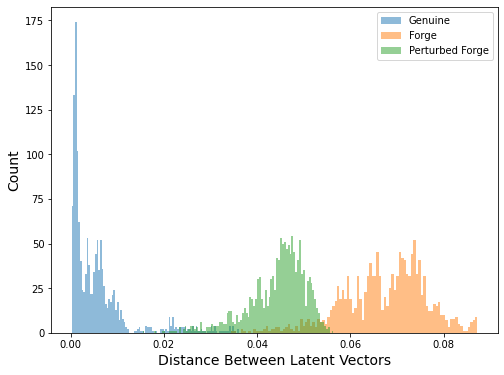

In [38]:
plt.figure(figsize=(8,6))
plt.hist(genuine_distances, bins=100, alpha=0.5, label="Genuine")
plt.hist(forge_distances, bins=100, alpha=0.5, label="Forge")
plt.hist(imp_distances, bins=100, alpha=0.5, label="Perturbed Forge")
plt.xlabel("Distance Between Latent Vectors", size=14)
plt.ylabel("Count", size=14)
# plt.title("Multiple Histograms with Matplotlib")
plt.legend(loc='upper right')
plt.savefig("distance_histogram_signet_128_leaky.png")
plt.show()

loading from checkpoint
Evaluating --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


1000/2760: Loss: 0.5499
2000/2760: Loss: 0.5498
2760/2760: Loss: 0.4967
computing accuracy of normal pairs...
confusion matrix for SigNet128 : [[1366, 14], [0, 1380]]
Accuracy: tensor(0.9949)
computing accuracy of improved forges...
confusion matrix for SigNet128 : [[0, 0], [91, 1289]]
Accuracy on improved forges: 0.46702897548675537
val loss: 0.4966573580144145


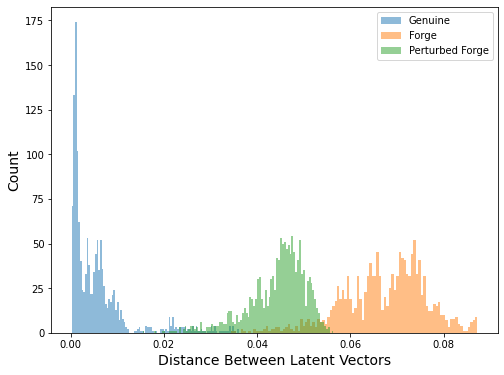

In [41]:
s = SigSystem(SigNet128())
s.load('_epoch_19')
result = s.evaluate(improve_forgery=True, leaky_accuracy=False)

val_loss, acc, distances, y, imp_distances, imp_y = result
same_id = y == 1
genuine_distances = distances[same_id]
forge_distances = distances[~same_id]

plt.figure(figsize=(8,6))
plt.hist(genuine_distances, bins=100, alpha=0.5, label="Genuine")
plt.hist(forge_distances, bins=100, alpha=0.5, label="Forge")
plt.hist(imp_distances, bins=100, alpha=0.5, label="Perturbed Forge")
plt.xlabel("Distance Between Latent Vectors", size=14)
plt.ylabel("Count", size=14)
# plt.title("Multiple Histograms with Matplotlib")
plt.legend(loc='upper right')
plt.savefig("distance_histogram_signet_128.png")
plt.show()

In [77]:
s = SigSystem(SigNet64())
s.load('_epoch_19')
result = s.evaluate(improve_forgery=True, leaky_accuracy=True)
s.threshold_d

loading from checkpoint
Evaluating --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


1000/2760: Loss: 0.5465
2000/2760: Loss: 0.5464
2760/2760: Loss: 0.4937
computing accuracy of normal pairs...
confusion matrix for SigNet64 : [[1380, 0], [23, 1357]]
best leaky accuracy threshold: tensor(0.0403)
Accuracy: tensor(0.9917)
computing accuracy of improved forges...
confusion matrix for SigNet64 : [[0, 0], [313, 1067]]
Accuracy on improved forges: 0.3865942060947418
val loss: 0.4937258152874099


tensor(0.0303)

In [78]:
s = SigSystem(SigNet128())
s.load('_epoch_19')
result = s.evaluate(improve_forgery=True, leaky_accuracy=True)
s.threshold_d

loading from checkpoint
Evaluating --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


1000/2760: Loss: 0.5499
2000/2760: Loss: 0.5498
2760/2760: Loss: 0.4967
computing accuracy of normal pairs...
confusion matrix for SigNet128 : [[1380, 0], [9, 1371]]
best leaky accuracy threshold: tensor(0.0402)
Accuracy: tensor(0.9967)
computing accuracy of improved forges...
confusion matrix for SigNet128 : [[0, 0], [296, 1084]]
Accuracy on improved forges: 0.39275363087654114
val loss: 0.49665735730183463


tensor(0.0338)

In [79]:
s = SigSystem(SigNet256())
s.load('_epoch_19')
result = s.evaluate(improve_forgery=True, leaky_accuracy=True)
s.threshold_d

loading from checkpoint
Evaluating --------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


1000/2760: Loss: 0.5471
2000/2760: Loss: 0.5469
2760/2760: Loss: 0.4940
computing accuracy of normal pairs...
confusion matrix for SigNet256 : [[1380, 0], [5, 1375]]
best leaky accuracy threshold: tensor(0.0401)
Accuracy: tensor(0.9982)
computing accuracy of improved forges...
confusion matrix for SigNet256 : [[0, 0], [350, 1030]]
Accuracy on improved forges: 0.37318840622901917
val loss: 0.49401053473997886


tensor(0.0325)

tensor(0.0335)

In [13]:
s = SigSystem(SigNet64())
s.load('_epoch_19')
s.find_threshold_simple()
s.save('_epoch_19')
result = s.evaluate(improve_forgery=True, imp_neg=True)

loading from checkpoint


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


medians: tensor(0.0053) tensor(0.0553)
Saving checkpoint.. _epoch_19
Evaluating --------------------
1000/2760: Loss: 0.5465
2000/2760: Loss: 0.5464
2760/2760: Loss: 0.4937
computing accuracy of normal pairs...
confusion matrix for SigNet64 : [[1347, 33], [0, 1380]]
Accuracy: tensor(0.9880)
computing accuracy of improved forges...
confusion matrix for SigNet64 : [[0, 0], [555, 825]]
Accuracy on improved forges: 0.29891303181648254
val loss: 0.4937258152874099


In [14]:
s = SigSystem(SigNet128())
s.load('_epoch_19')
s.find_threshold_simple()
s.save('_epoch_19')
result = s.evaluate(improve_forgery=True, imp_neg=True)

loading from checkpoint


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


medians: tensor(0.0025) tensor(0.0650)
Saving checkpoint.. _epoch_19
Evaluating --------------------
1000/2760: Loss: 0.5499
2000/2760: Loss: 0.5498
2760/2760: Loss: 0.4967
computing accuracy of normal pairs...
confusion matrix for SigNet128 : [[1367, 13], [0, 1380]]
Accuracy: tensor(0.9953)
computing accuracy of improved forges...
confusion matrix for SigNet128 : [[0, 0], [1240, 140]]
Accuracy on improved forges: 0.050724636763334274
val loss: 0.49665735730183463


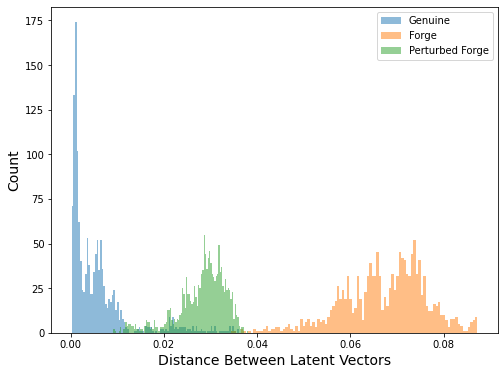

In [15]:
val_loss, acc, distances, y, imp_distances, imp_y = result
same_id = y == 1
genuine_distances = distances[same_id]
forge_distances = distances[~same_id]

plt.figure(figsize=(8,6))
plt.hist(genuine_distances, bins=100, alpha=0.5, label="Genuine")
plt.hist(forge_distances, bins=100, alpha=0.5, label="Forge")
plt.hist(imp_distances, bins=100, alpha=0.5, label="Perturbed Forge")
plt.xlabel("Distance Between Latent Vectors", size=14)
plt.ylabel("Count", size=14)
# plt.title("Multiple Histograms with Matplotlib")
plt.legend(loc='upper right')
plt.savefig("distance_histogram_signet_128.png")
plt.show()

In [18]:
files.download("distance_histogram_signet_128.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
s = SigSystem(SigNet256())
s.load('_epoch_19')
s.find_threshold_simple()
s.save('_epoch_19')
result = s.evaluate(improve_forgery=True, imp_neg=True)

loading from checkpoint


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


medians: tensor(0.0057) tensor(0.0593)
Saving checkpoint.. _epoch_19
Evaluating --------------------
1000/2760: Loss: 0.5471
2000/2760: Loss: 0.5469
2760/2760: Loss: 0.4940
computing accuracy of normal pairs...
confusion matrix for SigNet256 : [[1357, 23], [0, 1380]]
Accuracy: tensor(0.9917)
computing accuracy of improved forges...
confusion matrix for SigNet256 : [[0, 0], [938, 442]]
Accuracy on improved forges: 0.16014492511749268
val loss: 0.49401053473997886


In [20]:
s = SigSystem(SigNet64())
s.load('_epoch_4')
s.find_threshold_simple()
s.save('_epoch_4')
result = s.evaluate(improve_forgery=True, imp_neg=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


medians: tensor(4.3094) tensor(6.2988)
Saving checkpoint.. _epoch_4
Evaluating --------------------
1000/2760: Loss: 19.7972
2000/2760: Loss: 19.0370
2760/2760: Loss: 19.9400
computing accuracy of normal pairs...
confusion matrix for SigNet64 : [[1106, 274], [279, 1101]]
Accuracy: tensor(0.7996)
computing accuracy of improved forges...
confusion matrix for SigNet64 : [[0, 0], [43, 1337]]
Accuracy on improved forges: 0.4844202995300293
val loss: 19.93996666341588


In [21]:
s = SigSystem(SigNet128())
s.load('_epoch_4')
s.find_threshold_simple()
s.save('_epoch_4')
result = s.evaluate(improve_forgery=True, imp_neg=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


medians: tensor(5.1727) tensor(7.5175)
Saving checkpoint.. _epoch_4
Evaluating --------------------
1000/2760: Loss: 26.6620
2000/2760: Loss: 25.4193
2760/2760: Loss: 26.7876
computing accuracy of normal pairs...
confusion matrix for SigNet128 : [[1115, 265], [283, 1097]]
Accuracy: tensor(0.8014)
computing accuracy of improved forges...
confusion matrix for SigNet128 : [[0, 0], [0, 1380]]
Accuracy on improved forges: 0.5
val loss: 26.78763124562692


In [22]:
s = SigSystem(SigNet256())
s.load('_epoch_4')
s.find_threshold_simple()
s.save('_epoch_4')
result = s.evaluate(improve_forgery=True, imp_neg=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


medians: tensor(7.0072) tensor(9.6464)
Saving checkpoint.. _epoch_4
Evaluating --------------------
1000/2760: Loss: 46.7508
2000/2760: Loss: 43.7626
2760/2760: Loss: 45.8711
computing accuracy of normal pairs...
confusion matrix for SigNet256 : [[1071, 309], [180, 1200]]
Accuracy: tensor(0.8228)
computing accuracy of improved forges...
confusion matrix for SigNet256 : [[0, 0], [0, 1380]]
Accuracy on improved forges: 0.5
val loss: 45.87114810667176


In [17]:
from google.colab import files

In [40]:
files.download(sig_data_dir + 'distance_histogram_signet_128_leaky.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
files.download(sig_data_dir + 'distance_histogram_signet_128.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
t, r, a, f

(17071734784, 9313452032, 8625678848, 687773184)

17071734784

In [21]:
s.threshold_d

tensor(0.0591)

In [9]:
# do_training()

In [10]:
# save_file = sig_data_dir+'progress.pt'
# checkpoint = torch.load(save_file)
# # checkpoint['training_loss'] = checkpoint['loss']
# # del checkpoint['loss']
# torch.save(checkpoint, save_file)

In [12]:
save_file = sig_data_dir+'progress.pt' + '_epoch_0'
checkpoint = torch.load(save_file)
model = SigNet().to(device)
model.load_state_dict(checkpoint['model'])
criterion = ContrastiveLoss(alpha=1, beta=1, margin=1).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


medians: tensor(0.0281) tensor(0.2128)


In [25]:
torch.cuda.empty_cache()

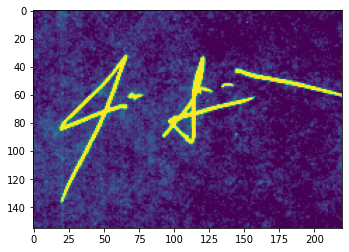

In [50]:
genuine = imgs[file_to_ind['original_1_1.png']]
plt.imshow(genuine.numpy().reshape((155, 220)))

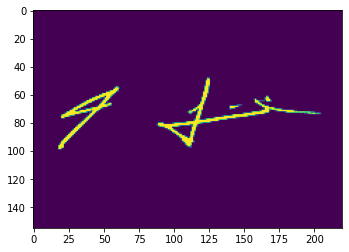

In [51]:
forge = imgs[file_to_ind['forgeries_1_1.png']]
plt.imshow(forge.numpy().reshape((155, 220)))

In [8]:
genuine

tensor([[[ 2.,  2., 15.,  ..., 15.,  0.,  0.],
         [ 2., 15., 15.,  ..., 40.,  0.,  0.],
         [28., 15., 15.,  ...,  2.,  0.,  0.],
         ...,
         [66., 40., 40.,  ...,  0.,  0.,  0.],
         [40., 28., 40.,  ...,  0.,  0.,  0.],
         [40., 15.,  2.,  ...,  0.,  0.,  0.]]])

In [9]:
forge

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [10]:
(genuine < 1).sum()

tensor(5204)

In [11]:
(genuine < 2).sum()

tensor(5204)

In [12]:
(genuine < 3).sum()

tensor(10257)

In [13]:
(genuine < 4).sum()

tensor(10257)

(array([5204.,    0., 5053.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0., 6169.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 6178.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 4875.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 2828.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 1285.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  514.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  222.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   86.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   63.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      

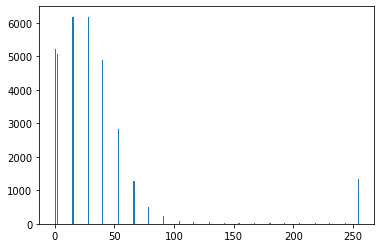

In [14]:
plt.hist(genuine.reshape(-1), bins=range(0, 256))

(array([3.3141e+04, 0.0000e+00, 1.7000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

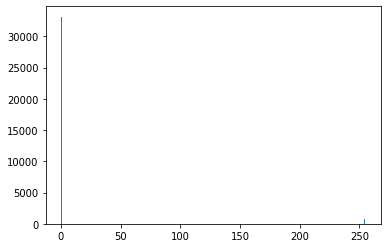

In [15]:
plt.hist(forge.reshape(-1), bins=range(0, 256))

In [19]:
genuine.int()

tensor([[[ 2,  2, 15,  ..., 15,  0,  0],
         [ 2, 15, 15,  ..., 40,  0,  0],
         [28, 15, 15,  ...,  2,  0,  0],
         ...,
         [66, 40, 40,  ...,  0,  0,  0],
         [40, 28, 40,  ...,  0,  0,  0],
         [40, 15,  2,  ...,  0,  0,  0]]], dtype=torch.int32)

In [21]:
torch.bincount(genuine.reshape(-1).int())

tensor([5204,    0, 5053,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 6169,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 6178,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 4875,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 2828,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 1285,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  514,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  222,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   86,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   63,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   44,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   37,    0,
           0,    0,    0,    0,    0,   

In [22]:
torch.bincount(forge.reshape(-1).int())

tensor([33141,     0,    17,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    14,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,    13,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           17,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    17,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    27,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,    15,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    11,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    16,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     8,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
x2_bincounts = []
ys = []
for batch_idx, (x1, x2, y) in enumerate(val_loader):
    x2_bincounts.append(torch.bincount(x2.reshape(-1).int(), minlength=256))
    ys.append(y)
y = torch.stack(ys).reshape(-1)
x2 = torch.stack(x2_bincounts).reshape((-1, 256)).float()
same_id = y == 1
genuine_mean = torch.mean(x2[same_id], dim=0)
forge_mean = torch.mean(x2[~same_id], dim=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

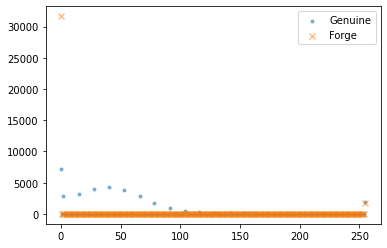

In [77]:
plt.scatter(range(256), genuine_mean, alpha=0.5, marker='.')
plt.scatter(range(256), forge_mean, alpha=0.5, marker='x')
plt.legend(['Genuine', 'Forge'])
save_file = sig_data_dir + 'mean_hist.png'
plt.savefig(save_file)
files.download(save_file)

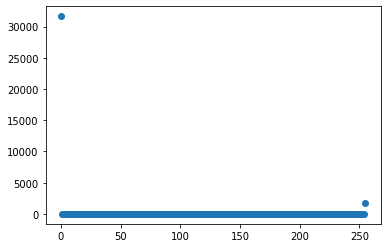

/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:2830: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  order=order, subok=True, ndmin=ndmin)
/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:2830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  order=order, subok=True, ndmin=ndmin)


ValueError: ignored

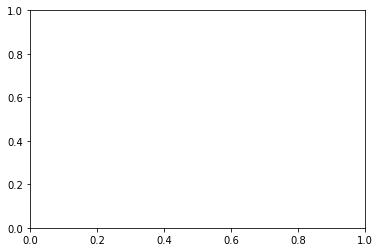

In [67]:
plt.scatter(range(256), [genuine_mean, forge_mean])

In [101]:
def heuristic_classifier(x2):
    return torch.logical_and(0 < x2, x2 < 255).sum() > 5000

In [102]:
num_correct = 0
total_num = 0
false_positives = 0
for batch_idx, (x1, x2, y) in enumerate(val_loader):
    prediction = heuristic_classifier(x2)
    correct = prediction == y
    false_positives += torch.logical_and(prediction, ~correct).sum()
    num_correct += correct.sum()
    total_num += len(y)
print(total_num, num_correct, false_positives, total_num - num_correct)

2760 tensor(2760) tensor(0) tensor(0)


In [52]:
forge_mean

tensor([3.1667e+04, 0.0000e+00, 5.5333e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9438e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3676e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0038e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8214e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.6251e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [53]:
genuine_mean

tensor([7149.7451,    0.0000, 2831.6333,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000, 3268.3811,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000, 3941.0369,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000, 4345.4043,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000, 3897.7964,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
        2816.8145,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
        1697.9333,    0.0000,    0.000

In [52]:
model = s.net
model

SigNet128(
  (features): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.3, inplace=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.3, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=119808, out_features=1024, bias=True)
    (14): Dropout2d(p=0.5, inplace=False)
    (15): Linear(in_features=1024, out_features=1

In [65]:
genuines = torch.reshape(genuine, (1, 1, 155, 220))
forges = torch.reshape(forge, (1, 1, 155, 220))
improved_forge, perturbations, target_outputs, outputs = s.improve_forge_neg(genuines, forges)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [72]:
perturbations[0][0]

tensor([[0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0000],
        [0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0000],
        [0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0000],
        ...,
        [0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

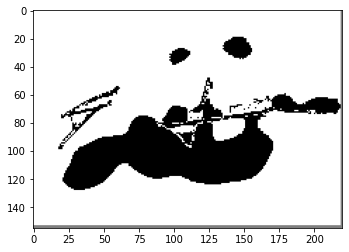

In [74]:
plt.imshow(perturbations[0][0].cpu(), cmap='gray')
plt.savefig('perturbation.png')
files.download('perturbation.png')

In [54]:
genuines = genuines.to(device)
forges = forges.to(device)
genuine_forge_dist = torch.pairwise_distance(model(genuines), model(forges), 2).item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [55]:
genuine_forge_dist

0.05991427227854729

In [56]:
genuine_improved_forge_dist = torch.pairwise_distance(model(genuines), model(improved_forge), 2).item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [57]:
genuine_improved_forge_dist

0.029870592057704926

In [39]:
s.threshold_d

tensor(0.0338)

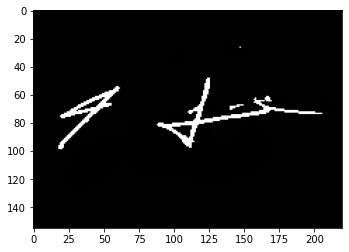

In [40]:
plt.imshow(improved_forge.cpu().detach().numpy().reshape((155, 220)), cmap='gray')

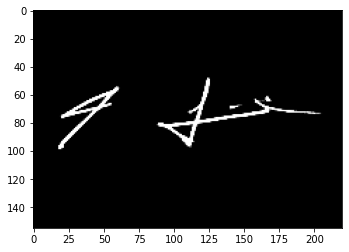

In [41]:
plt.imshow(-improved_forge.cpu().detach().numpy().reshape((155, 220)) + forge.cpu().detach().numpy().reshape((155, 220)), cmap='gray')

In [42]:
improved_forge.cpu() - forge

tensor([[[[0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0000],
          [0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0000],
          [0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0000],
          ...,
          [0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]],
       grad_fn=<SubBackward0>)

In [65]:
forge.max()

tensor(255.)

In [66]:
improved_forge[improved_forge < 1.0e-06] = 0.0

In [67]:
improved_forge

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0',
       grad_fn=<IndexPutBackward0>)

In [72]:
genuines = genuines.to(device)

In [73]:
torch.pairwise_distance(model(genuines), model(improved_forge), 2).item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.06897393614053726

In [79]:
(improved_forge.cpu() - forge).max()

tensor(1.4120e-05, grad_fn=<MaxBackward1>)

In [81]:
(forge).max()

tensor(255.)

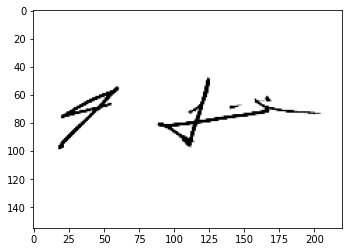

In [127]:
plt.imshow((improved_forge.detach().cpu() - forge.cpu()).reshape((155, 220)), cmap='gray')

In [125]:
(improved_forge.cpu() - forge.cpu()).reshape((155, 220))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ReshapeAliasBackward0>)

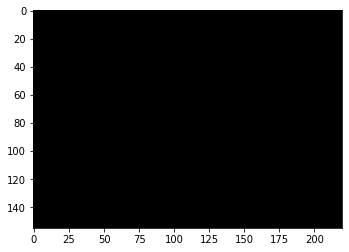

In [124]:
plt.imshow(np.zeros((155, 220)), cmap='gray')

In [102]:
std_dev = 0.07968917
noise = torch.rand_like(improved_forge.cpu()) * std_dev
noisy_forge = forge + noise

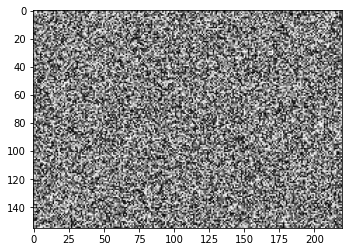

In [103]:
plt.imshow(noise.reshape((155, 220)), cmap='gray')

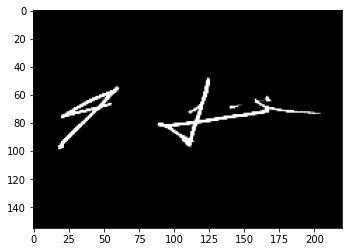

In [118]:
plt.imshow(noisy_forge.reshape((155, 220)), cmap='gray')

In [117]:
noisy_forge.reshape((155, 220))

tensor([[0.0208, 0.0559, 0.0682,  ..., 0.0505, 0.0428, 0.0210],
        [0.0358, 0.0789, 0.0738,  ..., 0.0599, 0.0074, 0.0206],
        [0.0646, 0.0465, 0.0761,  ..., 0.0662, 0.0321, 0.0250],
        ...,
        [0.0497, 0.0692, 0.0461,  ..., 0.0323, 0.0078, 0.0415],
        [0.0453, 0.0378, 0.0097,  ..., 0.0328, 0.0622, 0.0004],
        [0.0374, 0.0452, 0.0181,  ..., 0.0075, 0.0374, 0.0510]])

In [112]:
noise = noise.to(device)
torch.pairwise_distance(model(genuines), model(noise), 2).item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.03285594657063484

In [113]:
torch.pairwise_distance(model(genuines), model(noisy_forge.to(device)), 2).item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.11275295913219452

In [115]:
torch.pairwise_distance(model(genuines), model(torch.rand_like(improved_forge) * 255), 2).item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.03285594657063484

In [111]:
model.eval()

SigNet(
  (features): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.3, inplace=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.3, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=119808, out_features=1024, bias=True)
    (14): Dropout2d(p=0.5, inplace=False)
    (15): Linear(in_features=1024, out_features=256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


RuntimeError: ignored

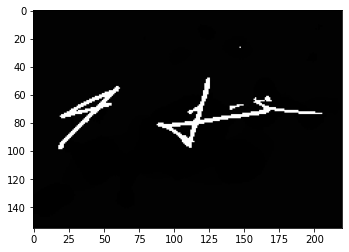

In [75]:
improved_forge = torch.autograd.Variable(improved_forge, requires_grad=False)
improved_forge, perturbations, target_outputs, outputs = s.improve_forge_neg(genuines, improved_forge)
plt.imshow(improved_forge.cpu().detach().numpy().reshape((155, 220)), cmap='gray')
torch.pairwise_distance(model(genuines), model(improved_forge), 2).item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.008246969431638718

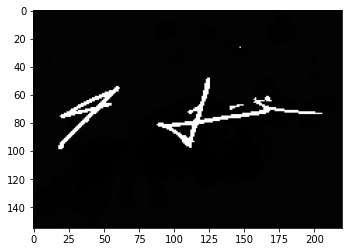

In [59]:
improved_forge = torch.autograd.Variable(improved_forge, requires_grad=False)
improved_forge = improved_forge, perturbations, target_outputs, outputs = s.improve_forge_neg(genuines, improved_forge)
plt.imshow(improved_forge.cpu().detach().numpy().reshape((155, 220)), cmap='gray')
torch.pairwise_distance(model(genuines), model(improved_forge), 2).item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.004368281457573175

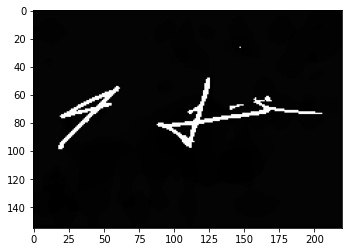

In [60]:
improved_forge = torch.autograd.Variable(improved_forge, requires_grad=False)
improved_forge = improved_forge, perturbations, target_outputs, outputs = s.improve_forge_neg(genuines, improved_forge)
plt.imshow(improved_forge.cpu().detach().numpy().reshape((155, 220)), cmap='gray')
torch.pairwise_distance(model(genuines), model(improved_forge), 2).item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.011001729406416416

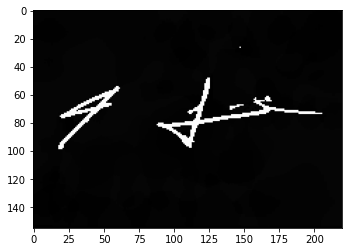

In [61]:
improved_forge = torch.autograd.Variable(improved_forge, requires_grad=False)
improved_forge = improved_forge, perturbations, target_outputs, outputs = s.improve_forge_neg(genuines, improved_forge)
plt.imshow(improved_forge.cpu().detach().numpy().reshape((155, 220)), cmap='gray')
torch.pairwise_distance(model(genuines), model(improved_forge), 2).item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.00455122347921133

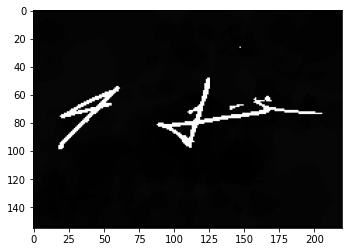

In [62]:
improved_forge = torch.autograd.Variable(improved_forge, requires_grad=False)
improved_forge = improved_forge, perturbations, target_outputs, outputs = s.improve_forge_neg(genuines, improved_forge)
plt.imshow(improved_forge.cpu().detach().numpy().reshape((155, 220)), cmap='gray')
torch.pairwise_distance(model(genuines), model(improved_forge), 2).item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.011193842627108097

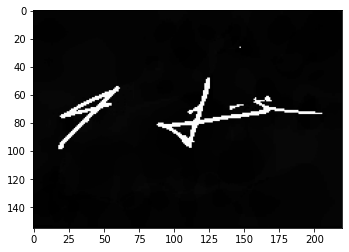

In [63]:
improved_forge = torch.autograd.Variable(improved_forge, requires_grad=False)
improved_forge = improved_forge, perturbations, target_outputs, outputs = s.improve_forge_neg(genuines, improved_forge)
plt.imshow(improved_forge.cpu().detach().numpy().reshape((155, 220)), cmap='gray')
torch.pairwise_distance(model(genuines), model(improved_forge), 2).item()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.004527568817138672

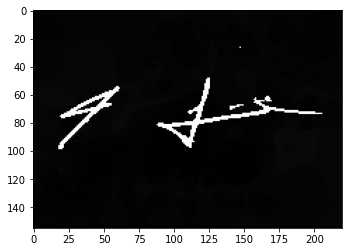

In [64]:
improved_forge = torch.autograd.Variable(improved_forge, requires_grad=False)
improved_forge = improved_forge, perturbations, target_outputs, outputs = s.improve_forge_neg(genuines, improved_forge)
plt.imshow(improved_forge.cpu().detach().numpy().reshape((155, 220)), cmap='gray')
torch.pairwise_distance(model(genuines), model(improved_forge), 2).item()